### 1. Análise de Performance de Vendas

### a. Volume de Vendas por Categoria

Identificar quais categorias de produtos têm o maior volume de vendas e em quais períodos (mensal, trimestral).


### Configuração do Ambiente e Carga de Dados

A primeira etapa consiste na preparação do ambiente de análise. O código a seguir importa as bibliotecas necessárias — **PySpark** para manipulação de dados e **Matplotlib/Seaborn** para visualização — e carrega os datasets do Unity Catalog para DataFrames Spark.

In [0]:
# Importa funções do PySpark, utilizando o alias 'F' como convenção.
from pyspark.sql import functions as F

# Importa bibliotecas para visualização de dados e manipulação com Pandas.
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd


# Carrega as tabelas de origem diretamente do Unity Catalog.
customers_df   = spark.table("workspace.default.olist_customers")
orders_df      = spark.table("workspace.default.olist_orders")
order_items_df = spark.table("workspace.default.olist_order_items")
payments_df    = spark.table("workspace.default.olist_order_payments")
reviews_df     = spark.table("workspace.default.olist_order_reviews")
products_df    = spark.table("workspace.default.olist_products")
sellers_df     = spark.table("workspace.default.olist_sellers")
geolocation_df = spark.table("workspace.default.olist_geolocation")


print("Datasets carregados com sucesso.")

Datasets carregados com sucesso.


### Etapa 2. Preparação e Limpeza dos Dados (ETL)

Nesta etapa, inicia-se o processo de **ETL (Extração, Transformação e Carga)**. O objetivo é converter os dados brutos de múltiplas tabelas em um único `DataFrame` otimizado para a análise de performance de vendas.

Esta fase é crucial, pois a qualidade dos dados preparados aqui determina a precisão de todas as análises futuras. O processo é executado na seguinte ordem:

1.  **Consolidação de Dados:** As informações de pedidos, itens de pedidos e produtos são unificadas. Utiliza-se a operação `join` para criar um DataFrame único que associa cada item vendido ao seu respectivo pedido e detalhes de produto.

2.  **Enriquecimento e Transformação:**
    * **Engenharia de Features:** A coluna de data da compra (`order_purchase_timestamp`) é utilizada para criar novas features temporais: `ano`, `mes` e `trimestre`. Estas colunas são fundamentais para a análise de sazonalidade.
    * **Limpeza de Dados:** Registros em que a categoria do produto (`product_category_name`) é nula são descartados. Esta filtragem garante que todas as vendas na base de análise possam ser corretamente atribuídas a uma categoria.

3.  **Projeção Final:** Por fim, o DataFrame é simplificado para conter apenas as colunas estritamente necessárias para a análise. Esta seleção (projeção) melhora a performance e a clareza do dataset final.

A célula de código a seguir executa exatamente estas operações.

In [0]:
# Etapa 2: Consolidação dos dados de vendas.
# Une as tabelas de pedidos, itens e produtos para formar a base da análise.
vendas_df = orders_df.join(
    order_items_df, on="order_id", how="inner"
).join(
    products_df, on="product_id", how="inner"
)

# Engenharia de features e limpeza.
# Extrai componentes de data e remove registros sem categoria de produto.
vendas_transformado_df = vendas_df.withColumn(
    "data_compra", F.to_timestamp(F.col("order_purchase_timestamp")) # Converte o campo para o tipo timestamp.
).withColumn(
    "ano", F.year(F.col("data_compra"))      # Extrai o ano da data da compra.
).withColumn(
    "mes", F.month(F.col("data_compra"))     # Extrai o mês da data da compra.
).withColumn(
    "trimestre", F.quarter(F.col("data_compra")) # Extrai o trimestre da data da compra.
).filter(
    F.col("product_category_name").isNotNull() # Filtra registros nulos para garantir a qualidade dos dados.
)

# Projeção final.
# Seleciona apenas as colunas essenciais para as análises subsequentes.
vendas_pronto_para_analise_df = vendas_transformado_df.select(
    "order_id",
    "product_id",
    "product_category_name",
    "price",
    "ano",
    "mes",
    "trimestre"
)

# Exibe uma amostra do dataframe final para verificação da transformação.
print("DataFrame transformado e pronto para análise:")
display(vendas_pronto_para_analise_df)

DataFrame transformado e pronto para análise:


order_id product_id product_category_name price ano mes trimestre 00010242fe8c5a6d1ba2dd792cb16214 4244733e06e7ecb4970a6e2683c13e61 cool_stuff 58.9 2017 9 3 00018f77f2f0320c557190d7a144bdd3 e5f2d52b802189ee658865ca93d83a8f pet_shop 239.9 2017 4 2 000229ec398224ef6ca0657da4fc703e c777355d18b72b67abbeef9df44fd0fd moveis_decoracao 199.0 2018 1 1 00024acbcdf0a6daa1e931b038114c75 7634da152a4610f1595efa32f14722fc perfumaria 12.99 2018 8 3 00042b26cf59d7ce69dfabb4e55b4fd9 ac6c3623068f30de03045865e4e10089 ferramentas_jardim 199.9 2017 2 1 00048cc3ae777c65dbb7d2a0634bc1ea ef92defde845ab8450f9d70c526ef70f utilidades_domesticas 21.9 2017 5 2 00054e8431b9d7675808bcb819fb4a32 8d4f2bb7e93e6710a28f34fa83ee7d28 telefonia 19.9 2017 12 4 000576fe39319847cbb9d288c5617fa6 557d850972a7d6f792fd18ae1400d9b6 ferramentas_jardim 810.0 2018 7 3 0005a1a1728c9d785b8e2b08b904576c 310ae3c140ff94b03219ad0adc3c778f beleza_saude 145.95 2018 3 1 0005f50442cb953dcd1d21e1fb923495 4535b0e1091c278dfd193e5a1d63b39f livros_tecnicos 53.99 2018 7 3 00061f2a7bc09da83e415a52dc8a4af1 d63c1011f49d98b976c352955b1c4bea beleza_saude 59.99 2018 3 1 00063b381e2406b52ad429470734ebd5 f177554ea93259a5b282f24e33f65ab6 fashion_bolsas_e_acessorios 45.0 2018 7 3 0006ec9db01a64e59a68b2c340bf65a7 99a4788cb24856965c36a24e339b6058 cama_mesa_banho 74.0 2018 7 3 0008288aa423d2a3f00fcb17cd7d8719 368c6c730842d78016ad823897a372db ferramentas_jardim 49.9 2018 2 1 0008288aa423d2a3f00fcb17cd7d8719 368c6c730842d78016ad823897a372db ferramentas_jardim 49.9 2018 2 1 0009792311464db532ff765bf7b182ae 8cab8abac59158715e0d70a36c807415 esporte_lazer 99.9 2018 8 3 0009c9a17f916a706d71784483a5d643 3f27ac8e699df3d300ec4a5d8c5cf0b2 consoles_games 639.0 2018 4 2 000aed2e25dbad2f9ddb70584c5a2ded 4fa33915031a8cde03dd0d3e8fb27f01 perfumaria 144.0 2018 5 2 000c3e6612759851cc3cbb4b83257986 b50c950aba0dcead2c48032a690ce817 esporte_lazer 99.0 2017 8 3 000e562887b1f2006d75e0be9558292e 5ed9eaf534f6936b51d0b6c5e4d5c2e9 cool_stuff 25.0 2018 2 1 000e63d38ae8c00bbcb5a30573b99628 553e0e7590d3116a072507a3635d2877 cama_mesa_banho 47.9 2018 3 1 000e906b789b55f64edcb1f84030f90d 57d79905de06d8897872c551bfd09358 telefonia 21.99 2017 11 4 000f25f4d72195062c040b12dce9a18a 1c05e0964302b6cf68ca0d15f326c6ba moveis_escritorio 119.99 2018 3 1 001021efaa8636c29475e7734483457d 5d7c23067ed3fc8c6e699b9373d5890b fashion_bolsas_e_acessorios 49.0 2018 2 1 0010b2e5201cc5f1ae7e9c6cc8f5bd00 5a419dbf24a8c9718fe522b81c69f61a cool_stuff 48.9 2017 9 3 00119ff934e539cf26f92b9ef0cdfed8 21b1c2f67a9aafb5af0eb06c13b9dbda esporte_lazer 219.9 2017 8 3 0011d82c4b53e22e84023405fb467e57 c389f712c4b4510bc997cee93e8b1a28 malas_acessorios 289.0 2018 1 1 00125cb692d04887809806618a2a145f 1c0c0093a48f13ba70d0c6b0a9157cb7 moveis_decoracao 109.9 2017 3 1 00130c0eee84a3d909e75bc08c5c3ca1 89321f94e35fc6d7903d36f74e351d40 alimentos 27.9 2018 6 2 0013503b13da1eac686219390b7d641b 38afdf723b95d455b418a0f57d623c6b moveis_decoracao 119.9 2017 12 4 00137e170939bba5a3134e2386413108 672e757f331900b9deea127a2a7b79fd agro_industria_e_comercio 397.0 2017 11 4 001427c0ec99cf8af737bd88e92fd444 28b4eced95a52d9c437a4caf9d311b95 moveis_decoracao 59.9 2018 4 2 00143d0f86d6fbd9f9b38ab440ac16f5 e95ee6822b66ac6058e2e4aff656071a esporte_lazer 21.33 2017 10 4 00143d0f86d6fbd9f9b38ab440ac16f5 e95ee6822b66ac6058e2e4aff656071a esporte_lazer 21.33 2017 10 4 00143d0f86d6fbd9f9b38ab440ac16f5 e95ee6822b66ac6058e2e4aff656071a esporte_lazer 21.33 2017 10 4 0014ae671de39511f7575066200733b7 23365beed316535b4105bd800c46670e telefonia 16.5 2017 5 2 0015ebb40fb17286bea51d4607c4733c 50fd2b788dc166edd20512370dac54df eletronicos 21.9 2018 1 1 00169e31ef4b29deaae414f9a5e95929 b10eba910a974df70b8a12d0665cdb9e cama_mesa_banho 39.0 2018 1 1 0016dfedd97fc2950e388d2971d718c7 4089861a1bd4685da70bddd6b4f974f1 ferramentas_jardim 49.75 2017 4 2 0017afd5076e074a48f1f1a4c7bac9c5 fe59a1e006df3ac42bf0ceb876d70969 informatica_acessorios 809.1 2017 4 2 001862358bf858722e1e2ae000cfed8b c6dd917a0be2a704582055949915ab32 cool_st

### Etapa 3. Carga dos Dados e Materialização

Esta célula conclui o pipeline de ETL. Após extrair, transformar e limpar os dados, o resultado é **materializado** em uma nova tabela no formato Delta Lake.

Salvar o `DataFrame` tratado como uma tabela permanente é uma prática fundamental em engenharia de dados por vários motivos:

* **Performance:** As análises subsequentes serão executadas diretamente sobre esta tabela otimizada, sendo muito mais rápidas do que reprocessar todas as transformações a cada consulta.
* **Checkpointing:** Cria um "ponto de verificação" seguro. A tabela `analise_vendas_por_categoria` passa a ser uma fonte de dados confiável e pré-processada (uma "golden table").
* **Reusabilidade:** Outros analistas, notebooks ou ferramentas de BI (como Power BI ou Tableau) podem consumir os dados diretamente desta tabela, sem precisar conhecer a complexidade do ETL original.

O uso do modo `overwrite` garante a idempotência do processo, ou seja, executar o notebook várias vezes sempre resultará no mesmo estado final consistente.

In [0]:
# Etapa 3: Carga e Materialização da Tabela de Análise.

# Define o nome completo da tabela de destino no Unity Catalog.
# Este será o artefato final do processo de ETL.
nome_tabela_final = "workspace.default.analise_vendas_por_categoria"

# Salva o DataFrame transformado como uma tabela Delta gerenciada.
vendas_pronto_para_analise_df.write.mode("overwrite").option(
    "overwriteSchema", "true"
).saveAsTable(nome_tabela_final)
# .mode("overwrite"): Garante que, a cada execução, a tabela seja recriada.
#                    Isso mantém os dados sempre consistentes com a última versão do código.
# .option("overwriteSchema", "true"): Permite que a estrutura (schema) da tabela seja
#                                    atualizada se o DataFrame sofrer alterações,
#                                    evitando erros de incompatibilidade.

# Imprime uma mensagem de confirmação, indicando que o processo foi concluído com sucesso.
print(f"ETL Concluído! A tabela '{nome_tabela_final}' foi criada/atualizada com sucesso.")

ETL Concluído! A tabela 'workspace.default.analise_vendas_por_categoria' foi criada/atualizada com sucesso.


### Etapa 4: Análise Exploratória de Dados (EDA)

Com os dados devidamente preparados e armazenados na tabela `analise_vendas_por_categoria`, esta seção inicia a **Análise Exploratória de Dados**. O primeiro objetivo é responder à pergunta de negócio fundamental:

**"Quais são as categorias de produtos com maior volume de vendas?"**

Para isso, a célula a seguir executa uma agregação simples, mas poderosa:

1.  **Carrega** a tabela de análise limpa.
2.  **Agrupa** os dados por categoria de produto (`product_category_name`).
3.  **Conta** o número total de pedidos (`order_id`) dentro de cada grupo.
4.  **Ordena** os resultados em ordem decrescente.

O resultado será um ranking que revela as categorias mais importantes para o negócio em termos de popularidade e volume de transações. Este ranking servirá de base para as visualizações e análises de sazonalidade subsequentes.

In [0]:
# Etapa 4: Análise de Volume - Ranking Geral de Categorias

# Carrega a tabela 'analise_vendas_por_categoria', que foi previamente tratada e salva.
# Utilizar esta tabela materializada garante performance e consistência na análise.
analise_df = spark.table("workspace.default.analise_vendas_por_categoria")

# Calcula o volume total de vendas (número de pedidos) para cada categoria.
# Este é o primeiro indicador chave de performance (KPI) a ser analisado.
volume_total_categoria = (
    analise_df.groupBy("product_category_name")         # Agrupa os registros por categoria de produto.
    .agg(F.count("order_id").alias("total_vendas"))      # Conta a quantidade de pedidos para cada categoria.
    .orderBy(F.col("total_vendas").desc())               # Ordena o resultado para criar o ranking das mais vendidas.
)

# Exibe na tela o DataFrame resultante com o ranking completo.
print("Volume de Vendas Geral por Categoria:")
display(volume_total_categoria)

Volume de Vendas Geral por Categoria:


product_category_name total_vendas cama_mesa_banho 11115 beleza_saude 9670 esporte_lazer 8641 moveis_decoracao 8334 informatica_acessorios 7827 utilidades_domesticas 6964 relogios_presentes 5991 telefonia 4545 ferramentas_jardim 4347 automotivo 4235 brinquedos 4117 cool_stuff 3796 perfumaria 3419 bebes 3065 eletronicos 2767 papelaria 2517 fashion_bolsas_e_acessorios 2031 pet_shop 1947 moveis_escritorio 1691 consoles_games 1137 malas_acessorios 1092 construcao_ferramentas_construcao 929 eletrodomesticos 771 instrumentos_musicais 680 eletroportateis 679 casa_construcao 604 livros_interesse_geral 553 alimentos 510 moveis_sala 503 casa_conforto 434 bebidas 379 audio 364 market_place 311 construcao_ferramentas_iluminacao 304 climatizacao 297 moveis_cozinha_area_de_servico_jantar_e_jardim 281 alimentos_bebidas 278 industria_comercio_e_negocios 268 livros_tecnicos 267 telefonia_fixa 264 fashion_calcados 262 eletrodomesticos_2 238 construcao_ferramentas_jardim 238 agro_industria_e_comercio 212 artes 209 pcs 203 sinalizacao_e_seguranca 199 construcao_ferramentas_seguranca 194 artigos_de_natal 153 fashion_roupa_masculina 132 fashion_underwear_e_moda_praia 131 moveis_quarto 109 construcao_ferramentas_ferramentas 103 tablets_impressao_imagem 83 portateis_casa_forno_e_cafe 76 cine_foto 72 dvds_blu_ray 64 livros_importados 60 fashion_roupa_feminina 48 artigos_de_festas 43 fraldas_higiene 39 musica 38 moveis_colchao_e_estofado 38 flores 33 casa_conforto_2 30 fashion_esporte 30 artes_e_artesanato 24 portateis_cozinha_e_preparadores_de_alimentos 15 cds_dvds_musicais 14 la_cuisine 14 pc_gamer 9 fashion_roupa_infanto_juvenil 8 seguros_e_servicos 2

### Etapa 5: Análise de Pareto: Identificando as Categorias Vitais

Em vez de criar um gráfico "Top 10", que utiliza um corte arbitrário, opta-se por uma **Análise de Pareto**. Esta técnica permite visualizar quais categorias são as "poucas vitais" que contribuem para a maior parte do resultado, em contraste com as "muitas triviais".

O gráfico a seguir combina:
* **Barras:** O volume de vendas individual de cada categoria, em ordem decrescente.
* **Linha:** O percentual acumulado do volume total de vendas.

O objetivo é identificar o conjunto de categorias que representa aproximadamente **80% de todo o volume de vendas**, fornecendo um foco estratégico claro para o negócio.

/home/spark-5ca03db1-d44b-4874-b299-e8/.ipykernel/15225/command-6266236999689623-1733971835:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


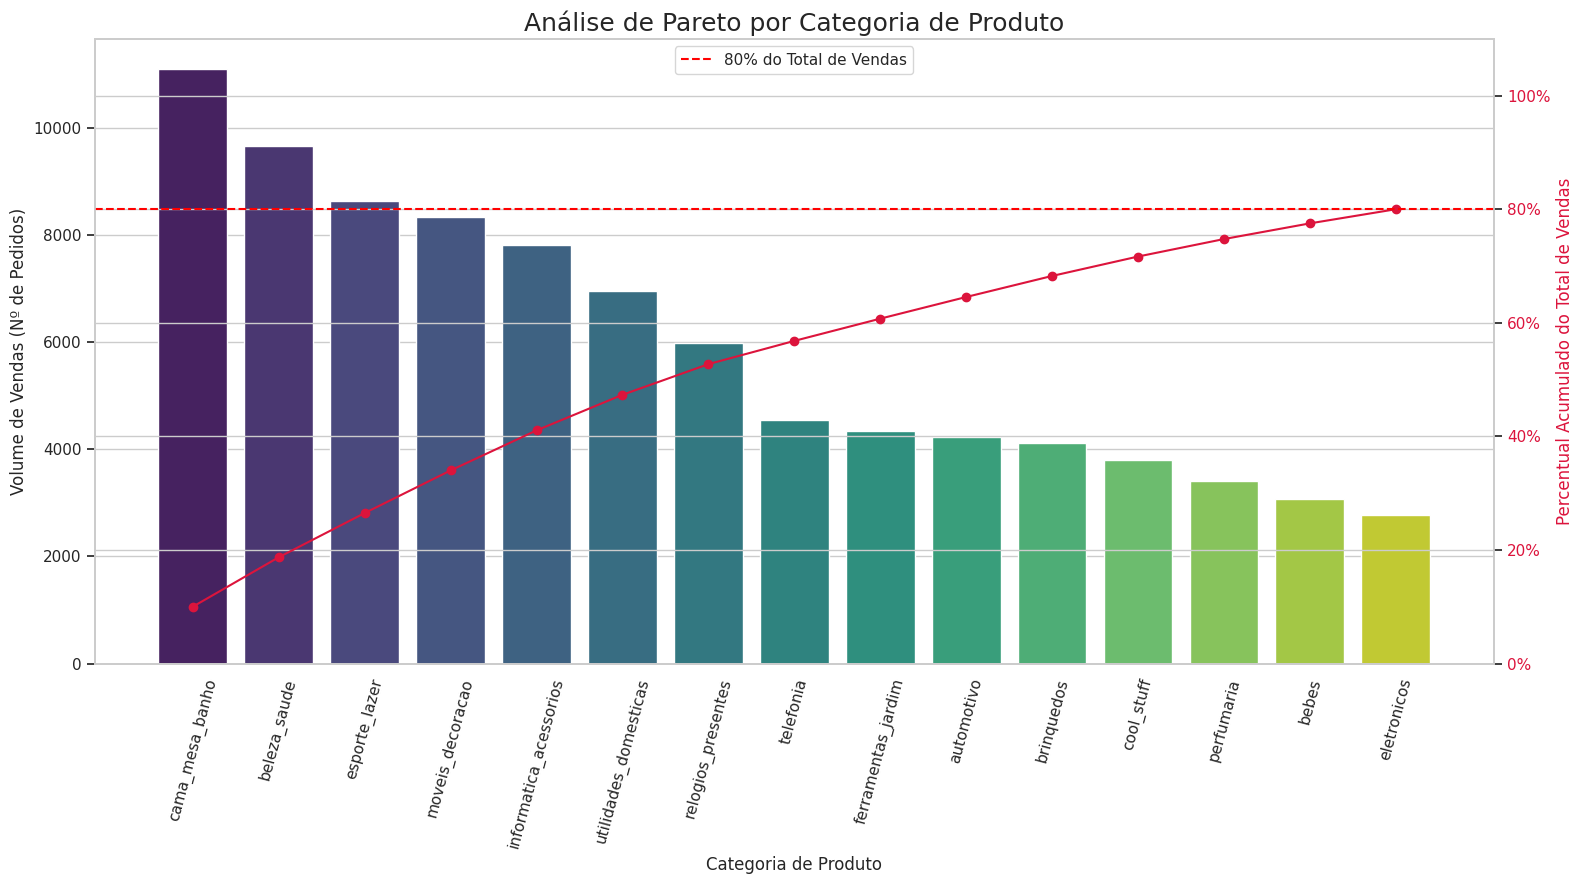

In [0]:
# Etapa 5: Visualização com Gráfico de Pareto

# Reutiliza o DataFrame com o ranking completo, que já está em memória e ordenado.
# Converte para Pandas para facilitar os cálculos de acumulação e a plotagem.
df_pareto = volume_total_categoria.toPandas()

# Calcula a porcentagem de contribuição de cada categoria e o acumulado.
df_pareto["percentual"] = 100 * (df_pareto["total_vendas"] / df_pareto["total_vendas"].sum())
df_pareto["percentual_acumulado"] = df_pareto["percentual"].cumsum()

# Criação do Gráfico de Pareto 

# Define o tema e o tamanho da figura.
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(16, 9))

# Eixo 1 (Barras): Plota o volume de vendas por categoria.
# Limita-se a visualização às 15 primeiras categorias para não poluir o gráfico.
sns.barplot(
    data=df_pareto.head(15), 
    x="product_category_name", 
    y="total_vendas", 
    palette="viridis", 
    ax=ax1
)
ax1.set_title("Análise de Pareto por Categoria de Produto", fontsize=18)
ax1.set_xlabel("Categoria de Produto", fontsize=12)
ax1.set_ylabel("Volume de Vendas (Nº de Pedidos)", fontsize=12)
ax1.tick_params(axis="x", rotation=75) # Rotaciona os nomes das categorias.

# Eixo 2 (Linha): Plota o percentual acumulado.
ax2 = ax1.twinx() # Cria um segundo eixo Y que compartilha o eixo X.
ax2.plot(df_pareto["product_category_name"].head(15), df_pareto["percentual_acumulado"].head(15), color="crimson", marker="o")
ax2.yaxis.set_major_formatter(PercentFormatter()) # Formata o eixo Y como porcentagem.
ax2.set_ylabel("Percentual Acumulado do Total de Vendas", fontsize=12, color="crimson")
ax2.tick_params(axis="y", labelcolor="crimson")
ax2.set_ylim(0, 110) # Define o limite do eixo de porcentagem.

# Linha de referência de 80% (Princípio de Pareto)
ax2.axhline(y=80, color="red", linestyle="--", linewidth=1.5, label="80% do Total de Vendas")
ax2.legend(loc='upper center')

plt.tight_layout()
display(fig)

### Etapa 6: Análise de Sazonalidade - Preparação dos Dados Temporais

Após identificar *quais* categorias são mais importantes, a análise agora foca em responder **"quando"** ocorrem as vendas. Para investigar padrões de sazonalidade, é necessário agregar os dados em diferentes granularidades de tempo.

A célula a seguir prepara dois DataFrames agregados:

1.  **Volume Mensal:** Fornece uma visão detalhada das flutuações de vendas, ideal para identificar picos de vendas relacionados a eventos específicos, como a Black Friday.
2.  **Volume Trimestral:** Oferece uma perspectiva mais estratégica, suavizando a volatilidade mensal e destacando os padrões sazonais mais amplos ao longo do ano.

Ambos os DataFrames serão a fonte de dados para os gráficos de linha na sequência da análise.

In [0]:
# Etapa 6: Preparação dos Dados para Análise de Sazonalidade

# Garante o carregamento da tabela de análise. Esta ação torna a célula
# independente de execuções anteriores no mesmo notebook.
analise_df = spark.table("workspace.default.analise_vendas_por_categoria")

# Agregação de Dados Mensais 
# Agrupa os dados por ano, mês e categoria para calcular o volume de vendas mensal.
# Este DataFrame é a base para a visualização de tendências de curto prazo.
volume_mensal_categoria = analise_df.groupBy("ano", "mes", "product_category_name").agg(
    F.count("order_id").alias("total_vendas")
).orderBy("ano", "mes")

# Exibe uma amostra do resultado da agregação mensal.
print("Volume de Vendas Mensal por Categoria (Amostra):")
display(volume_mensal_categoria)


# Agregação de Dados Trimestrais
# Agrupa os dados por ano, trimestre e categoria para uma visão de médio prazo.
# A agregação trimestral ajuda a suavizar ruídos e a identificar tendências sazonais mais amplas.
volume_trimestral_categoria = analise_df.groupBy("ano", "trimestre", "product_category_name").agg(
    F.count("order_id").alias("total_vendas")
).orderBy("ano", "trimestre")

# Exibe uma amostra do resultado da agregação trimestral.
print("\nVolume de Vendas Trimestral por Categoria (Amostra):")
display(volume_trimestral_categoria)

Volume de Vendas Mensal por Categoria (Amostra):


ano mes product_category_name total_vendas 2016 9 telefonia 1 2016 9 beleza_saude 3 2016 9 moveis_decoracao 2 2016 10 market_place 13 2016 10 alimentos 1 2016 10 automotivo 12 2016 10 livros_interesse_geral 1 2016 10 informatica_acessorios 21 2016 10 esporte_lazer 19 2016 10 moveis_decoracao 67 2016 10 consoles_games 10 2016 10 industria_comercio_e_negocios 4 2016 10 bebes 14 2016 10 eletronicos 2 2016 10 climatizacao 10 2016 10 cama_mesa_banho 8 2016 10 fashion_roupa_feminina 1 2016 10 cool_stuff 8 2016 10 relogios_presentes 5 2016 10 telefonia 10 2016 10 fashion_calcados 1 2016 10 audio 2 2016 10 pet_shop 4 2016 10 livros_tecnicos 1 2016 10 brinquedos 27 2016 10 fraldas_higiene 1 2016 10 fashion_bolsas_e_acessorios 9 2016 10 utilidades_domesticas 12 2016 10 telefonia_fixa 5 2016 10 beleza_saude 48 2016 10 fashion_roupa_masculina 1 2016 10 perfumaria 33 2016 10 ferramentas_jardim 5 2016 10 moveis_escritorio 6 2016 12 fashion_bolsas_e_acessorios 1 2017 1 pet_shop 15 2017 1 informatica_acessorios 31 2017 1 casa_conforto_2 2 2017 1 moveis_quarto 8 2017 1 market_place 6 2017 1 fashion_bolsas_e_acessorios 35 2017 1 consoles_games 23 2017 1 ferramentas_jardim 58 2017 1 alimentos 2 2017 1 eletroportateis 6 2017 1 relogios_presentes 11 2017 1 fashion_underwear_e_moda_praia 2 2017 1 brinquedos 43 2017 1 utilidades_domesticas 28 2017 1 agro_industria_e_comercio 3 2017 1 cool_stuff 40 2017 1 malas_acessorios 5 2017 1 dvds_blu_ray 2 2017 1 fashion_calcados 1 2017 1 moveis_escritorio 10 2017 1 fashion_roupa_masculina 1 2017 1 pcs 1 2017 1 eletrodomesticos_2 8 2017 1 moveis_cozinha_area_de_servico_jantar_e_jardim 1 2017 1 climatizacao 4 2017 1 telefonia 26 2017 1 perfumaria 34 2017 1 papelaria 14 2017 1 cama_mesa_banho 48 2017 1 instrumentos_musicais 1 2017 1 musica 2 2017 1 construcao_ferramentas_construcao 1 2017 1 livros_interesse_geral 2 2017 1 esporte_lazer 80 2017 1 bebes 41 2017 1 telefonia_fixa 22 2017 1 fashion_roupa_feminina 2 2017 1 beleza_saude 85 2017 1 moveis_sala 10 2017 1 automotivo 34 2017 1 moveis_decoracao 182 2017 1 eletronicos 11 2017 1 seguros_e_servicos 1 2017 2 fashion_calcados 3 2017 2 ferramentas_jardim 72 2017 2 casa_conforto 3 2017 2 market_place 22 2017 2 casa_construcao 4 2017 2 fashion_roupa_masculina 7 2017 2 moveis_cozinha_area_de_servico_jantar_e_jardim 2 2017 2 cool_stuff 70 2017 2 instrumentos_musicais 9 2017 2 moveis_sala 24 2017 2 eletronicos 19 2017 2 fashion_bolsas_e_acessorios 39 2017 2 audio 5 2017 2 utilidades_domesticas 81 2017 2 livros_interesse_geral 8 2017 2 dvds_blu_ray 1 2017 2 malas_acessorios 21 2017 2 industria_comercio_e_negocios 1 2017 2 consoles_games 18 2017 2 esporte_lazer 156 2017 2 moveis_escritorio 63 2017 2 eletrodomesticos_2 1 2017 2 telefonia_fixa 22 2017 2 livros_importados 1 2017 2 agro_industria_e_comercio 7 2017 2 moveis_decoracao 266 2017 2 brinquedos 67 2017 2 perfumaria 51 2017 2 bebes 34 2017 2 pcs 1 2017 2 informatica_acessorios 106 2017 2 automotivo 86 2017 2 construcao_ferramentas_construcao 3 2017 2 tablets_impressao_imagem 8 2017 2 moveis_quarto 1 2017 2 relogios_presentes 37 2017 2 pet_shop 40 2017 2 telefonia 111 2017 2 beleza_saude 166 2017 2 livros_tecnicos 1 2017 2 fashion_underwear_e_moda_praia 8 2017 2 construcao_ferramentas_jardim 2 2017 2 eletrodomesticos 7 2017 2 alimentos 9 2017 2 papelaria 19 2017 2 eletroportateis 28 2017 2 climatizacao 12 2017 2 fashion_roupa_feminina 4 2017 2 construcao_ferramentas_seguranca 1 2017 2 cama_mesa_banho 165 2017 2 cine_foto 1 2017 3 ferramentas_jardim 150 2017 3 dvds_blu_ray 5 2017 3 perfumaria 106 2017 3 bebes 44 2017 3 market_place 17 2017 3 papelaria 56 2017 3 telefonia_fixa 21 2017 3 moveis_escritorio 78 2017 3 fashion_esporte 1 2017 3 fashion_roupa_feminina 1 2017 3 climatizacao 17 2017 3 eletrodomesticos 10 2017 3 eletrodomesticos_2 2 2017 3 brinquedos 103 2017 3 pet_shop 45 2017 3 casa_conforto_2 3 2017 3 audio 14 2017 3 artes 5 2017 3 fashion_calcados 14 2017 3 moveis_decoracao 328 2017 3 agro_industria_e_comerci


Volume de Vendas Trimestral por Categoria (Amostra):


ano trimestre product_category_name total_vendas 2016 3 beleza_saude 3 2016 3 moveis_decoracao 2 2016 3 telefonia 1 2016 4 fashion_bolsas_e_acessorios 10 2016 4 moveis_decoracao 67 2016 4 climatizacao 10 2016 4 cama_mesa_banho 8 2016 4 beleza_saude 48 2016 4 industria_comercio_e_negocios 4 2016 4 utilidades_domesticas 12 2016 4 ferramentas_jardim 5 2016 4 livros_tecnicos 1 2016 4 consoles_games 10 2016 4 pet_shop 4 2016 4 cool_stuff 8 2016 4 telefonia_fixa 5 2016 4 esporte_lazer 19 2016 4 livros_interesse_geral 1 2016 4 automotivo 12 2016 4 telefonia 10 2016 4 relogios_presentes 5 2016 4 fashion_roupa_feminina 1 2016 4 audio 2 2016 4 informatica_acessorios 21 2016 4 alimentos 1 2016 4 fraldas_higiene 1 2016 4 fashion_calcados 1 2016 4 brinquedos 27 2016 4 market_place 13 2016 4 perfumaria 33 2016 4 moveis_escritorio 6 2016 4 fashion_roupa_masculina 1 2016 4 bebes 14 2016 4 eletronicos 2 2017 1 dvds_blu_ray 8 2017 1 construcao_ferramentas_jardim 2 2017 1 tablets_impressao_imagem 13 2017 1 fashion_underwear_e_moda_praia 16 2017 1 beleza_saude 462 2017 1 moveis_cozinha_area_de_servico_jantar_e_jardim 6 2017 1 fashion_calcados 18 2017 1 fashion_roupa_masculina 17 2017 1 eletronicos 67 2017 1 automotivo 207 2017 1 telefonia 309 2017 1 market_place 45 2017 1 perfumaria 191 2017 1 casa_construcao 14 2017 1 livros_interesse_geral 35 2017 1 cama_mesa_banho 502 2017 1 audio 19 2017 1 brinquedos 213 2017 1 musica 3 2017 1 livros_tecnicos 3 2017 1 malas_acessorios 64 2017 1 instrumentos_musicais 20 2017 1 livros_importados 1 2017 1 relogios_presentes 129 2017 1 agro_industria_e_comercio 12 2017 1 casa_conforto 16 2017 1 papelaria 89 2017 1 sinalizacao_e_seguranca 1 2017 1 esporte_lazer 435 2017 1 moveis_quarto 9 2017 1 cine_foto 1 2017 1 pet_shop 100 2017 1 consoles_games 91 2017 1 fashion_roupa_feminina 7 2017 1 climatizacao 33 2017 1 moveis_sala 58 2017 1 ferramentas_jardim 280 2017 1 telefonia_fixa 65 2017 1 utilidades_domesticas 313 2017 1 bebes 119 2017 1 alimentos 35 2017 1 artes 5 2017 1 eletrodomesticos 17 2017 1 construcao_ferramentas_seguranca 3 2017 1 construcao_ferramentas_construcao 8 2017 1 moveis_decoracao 776 2017 1 casa_conforto_2 5 2017 1 fashion_esporte 1 2017 1 bebidas 5 2017 1 eletrodomesticos_2 11 2017 1 informatica_acessorios 311 2017 1 seguros_e_servicos 1 2017 1 pcs 2 2017 1 moveis_escritorio 151 2017 1 fashion_bolsas_e_acessorios 142 2017 1 alimentos_bebidas 5 2017 1 cool_stuff 233 2017 1 industria_comercio_e_negocios 3 2017 1 eletroportateis 65 2017 2 construcao_ferramentas_jardim 20 2017 2 moveis_colchao_e_estofado 4 2017 2 beleza_saude 739 2017 2 moveis_sala 61 2017 2 market_place 58 2017 2 automotivo 325 2017 2 perfumaria 404 2017 2 eletroportateis 62 2017 2 construcao_ferramentas_ferramentas 3 2017 2 industria_comercio_e_negocios 4 2017 2 artes_e_artesanato 1 2017 2 artes 19 2017 2 musica 6 2017 2 instrumentos_musicais 57 2017 2 malas_acessorios 180 2017 2 climatizacao 35 2017 2 pet_shop 188 2017 2 cama_mesa_banho 1025 2017 2 dvds_blu_ray 10 2017 2 telefonia 529 2017 2 consoles_games 76 2017 2 casa_conforto 72 2017 2 pc_gamer 4 2017 2 moveis_quarto 16 2017 2 portateis_casa_forno_e_cafe 1 2017 2 moveis_cozinha_area_de_servico_jantar_e_jardim 22 2017 2 moveis_decoracao 715 2017 2 eletrodomesticos 81 2017 2 cine_foto 4 2017 2 telefonia_fixa 33 2017 2 casa_construcao 20 2017 2 bebes 237 2017 2 eletronicos 158 2017 2 ferramentas_jardim 374 2017 2 moveis_escritorio 164 2017 2 esporte_lazer 811 2017 2 livros_importados 3 2017 2 la_cuisine 2 2017 2 artigos_de_natal 4 2017 2 fashion_calcados 65 2017 2 alimentos 12 2017 2 fashion_roupa_masculina 21 2017 2 fashion_roupa_infanto_juvenil 2 2017 2 bebidas 9 2017 2 alimentos_bebidas 22 2017 2 tablets_impressao_imagem 24 2017 2 relogios_presentes 356 2017 2 fashion_bolsas_e_acessorios 243 2017 2 fashion_roupa_feminina 9 2017 2 brinquedos 471 2017 2 cool_stuff 569 2017 2 eletrodomesticos_2 17 2017 2 informatica_acessorios 717 2017 2 livros_tecnicos 6 2017 2 livros_interesse_

### Etapa 8: Sazonalidade das Categorias Estratégicas

Dando continuidade à análise de Pareto, o foco agora é entender o comportamento de vendas das categorias mais relevantes ao longo do tempo.

Em vez de selecionar um número arbitrário de categorias (como "Top 5"), a análise a seguir visualiza a sazonalidade trimestral daquelas que, somadas, **representam aproximadamente 60% de todo o volume de vendas**. Essa abordagem, orientada por dados, garante que o esforço de análise seja direcionado às categorias que de fato possuem maior impacto para o negócio.

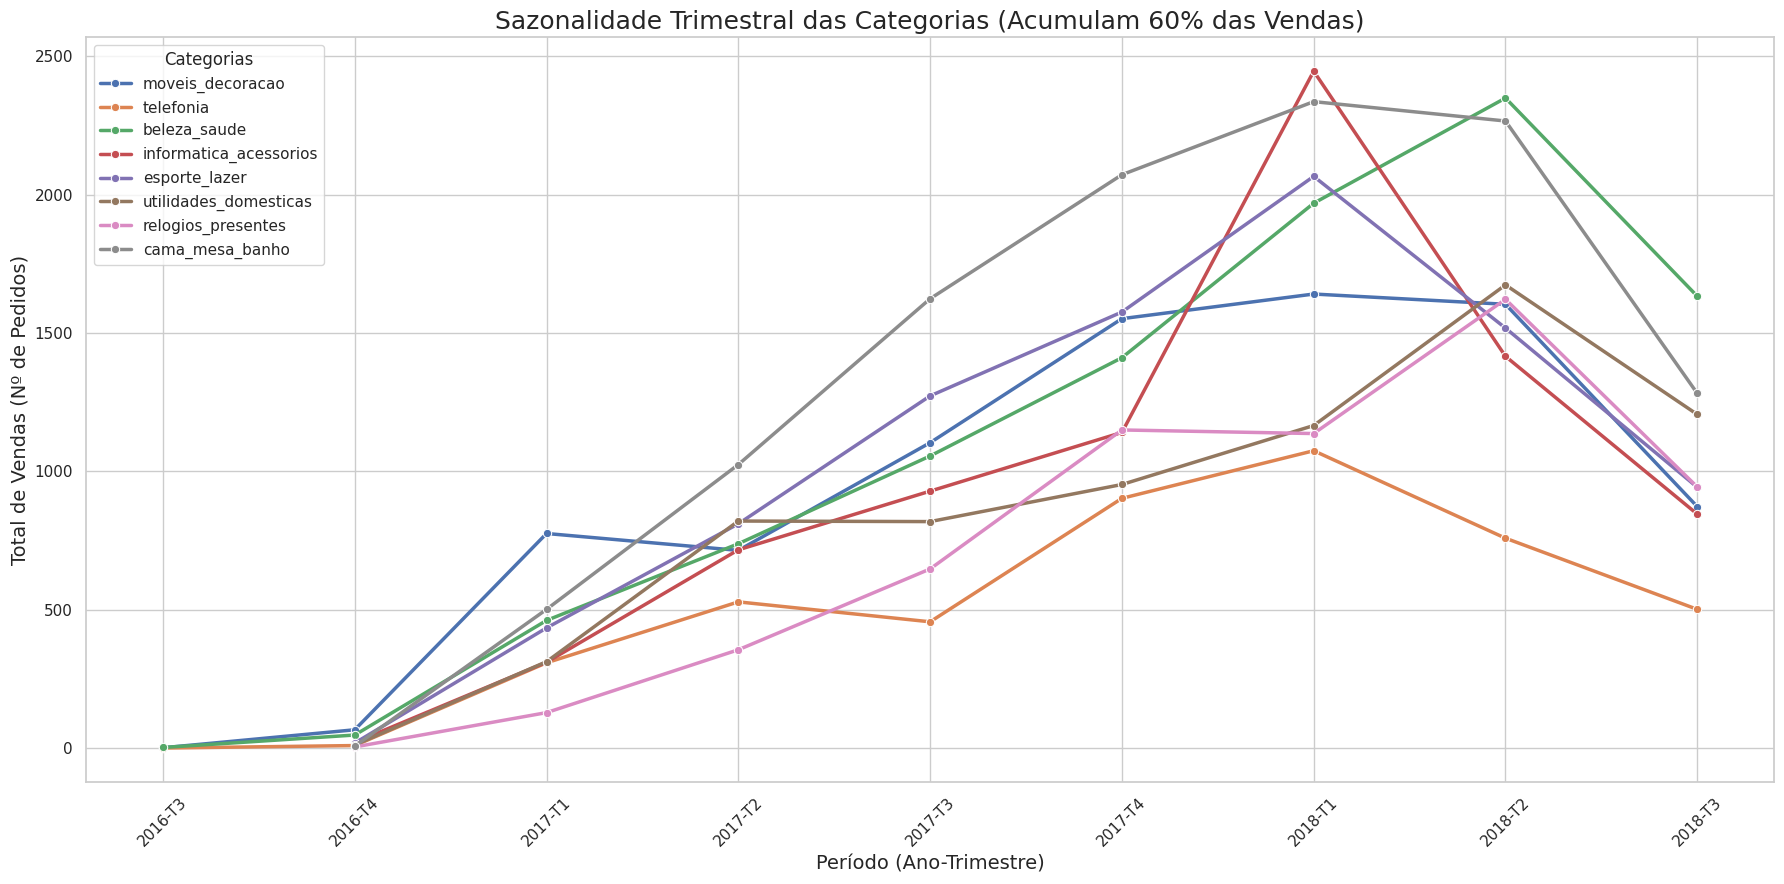

In [0]:
# Etapa 8: Visualização da Sazonalidade das Categorias Principais

# 1. Reutiliza-se o DataFrame da análise de Pareto para uma seleção de categorias baseada em dados.
# O DataFrame 'df_pareto' (Pandas) deve estar disponível da célula anterior.
# Define-se um limiar de 60% para focar nas categorias de maior impacto.
limiar_percentual = 60
categorias_principais = df_pareto[df_pareto['percentual_acumulado'] <= limiar_percentual]
lista_categorias_principais = categorias_principais['product_category_name'].tolist()

# 2. Filtra-se o DataFrame Spark ('volume_trimestral_categoria') para conter apenas
# as categorias de maior relevância, identificadas acima.
vendas_trimestrais_principais_df = volume_trimestral_categoria.filter(
    F.col("product_category_name").isin(lista_categorias_principais)
)

# 3. Prepara-se o DataFrame para a visualização.
# Cria-se a coluna 'periodo' (ex: "2017-T1") e ordena-se cronologicamente.
vendas_trimestrais_pd = vendas_trimestrais_principais_df.withColumn(
    "periodo", 
    F.concat(F.col("ano"), F.lit("-T"), F.col("trimestre"))
).orderBy("ano", "trimestre").toPandas()


# 4. Cria-se o gráfico de linhas para a análise de tendência trimestral.
plt.figure(figsize=(18, 9))
sns.set_theme(style="whitegrid")

sns.lineplot(
    data=vendas_trimestrais_pd,
    x="periodo",
    y="total_vendas",
    hue="product_category_name",
    marker="o",
    linewidth=2.5
)

# 5. Adiciona-se títulos e rótulos descritivos que refletem a metodologia.
plt.title(f"Sazonalidade Trimestral das Categorias (Acumulam {limiar_percentual}% das Vendas)", fontsize=18)
plt.xlabel("Período (Ano-Trimestre)", fontsize=14)
plt.ylabel("Total de Vendas (Nº de Pedidos)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Categorias", loc='upper left')
plt.tight_layout()

# Exibe o gráfico no notebook.
display(plt.gcf())

### Etapa 9: Análise Comparativa: Comportamento Sazonal das Categorias Estratégicas

Esta é a visualização conclusiva da análise. Após identificar as categorias mais relevantes através do Princípio de Pareto, o objetivo agora é comparar seus padrões de vendas mensais em um único gráfico, lado a lado.

Esta análise busca responder a perguntas de negócio importantes:

* **Padrões Comuns:** As categorias de maior impacto para o negócio compartilham dos mesmos picos e vales de vendas ao longo do ano? O pico observado em novembro, por exemplo, é um fenômeno generalizado entre elas?
* **Crescimento e Evolução:** Como a sazonalidade e o volume de vendas dessas categorias evoluíram ao longo do tempo (de 2016 a 2018)?
* **Comportamentos Atípicos:** Existe alguma categoria estratégica que apresenta um comportamento de vendas distinto das demais?

Para isso, a célula de código a seguir plota a série temporal completa de vendas mensais para o grupo de categorias que, somadas, representam 60% do volume total de pedidos, oferecendo uma visão comparativa direta de suas trajetórias.

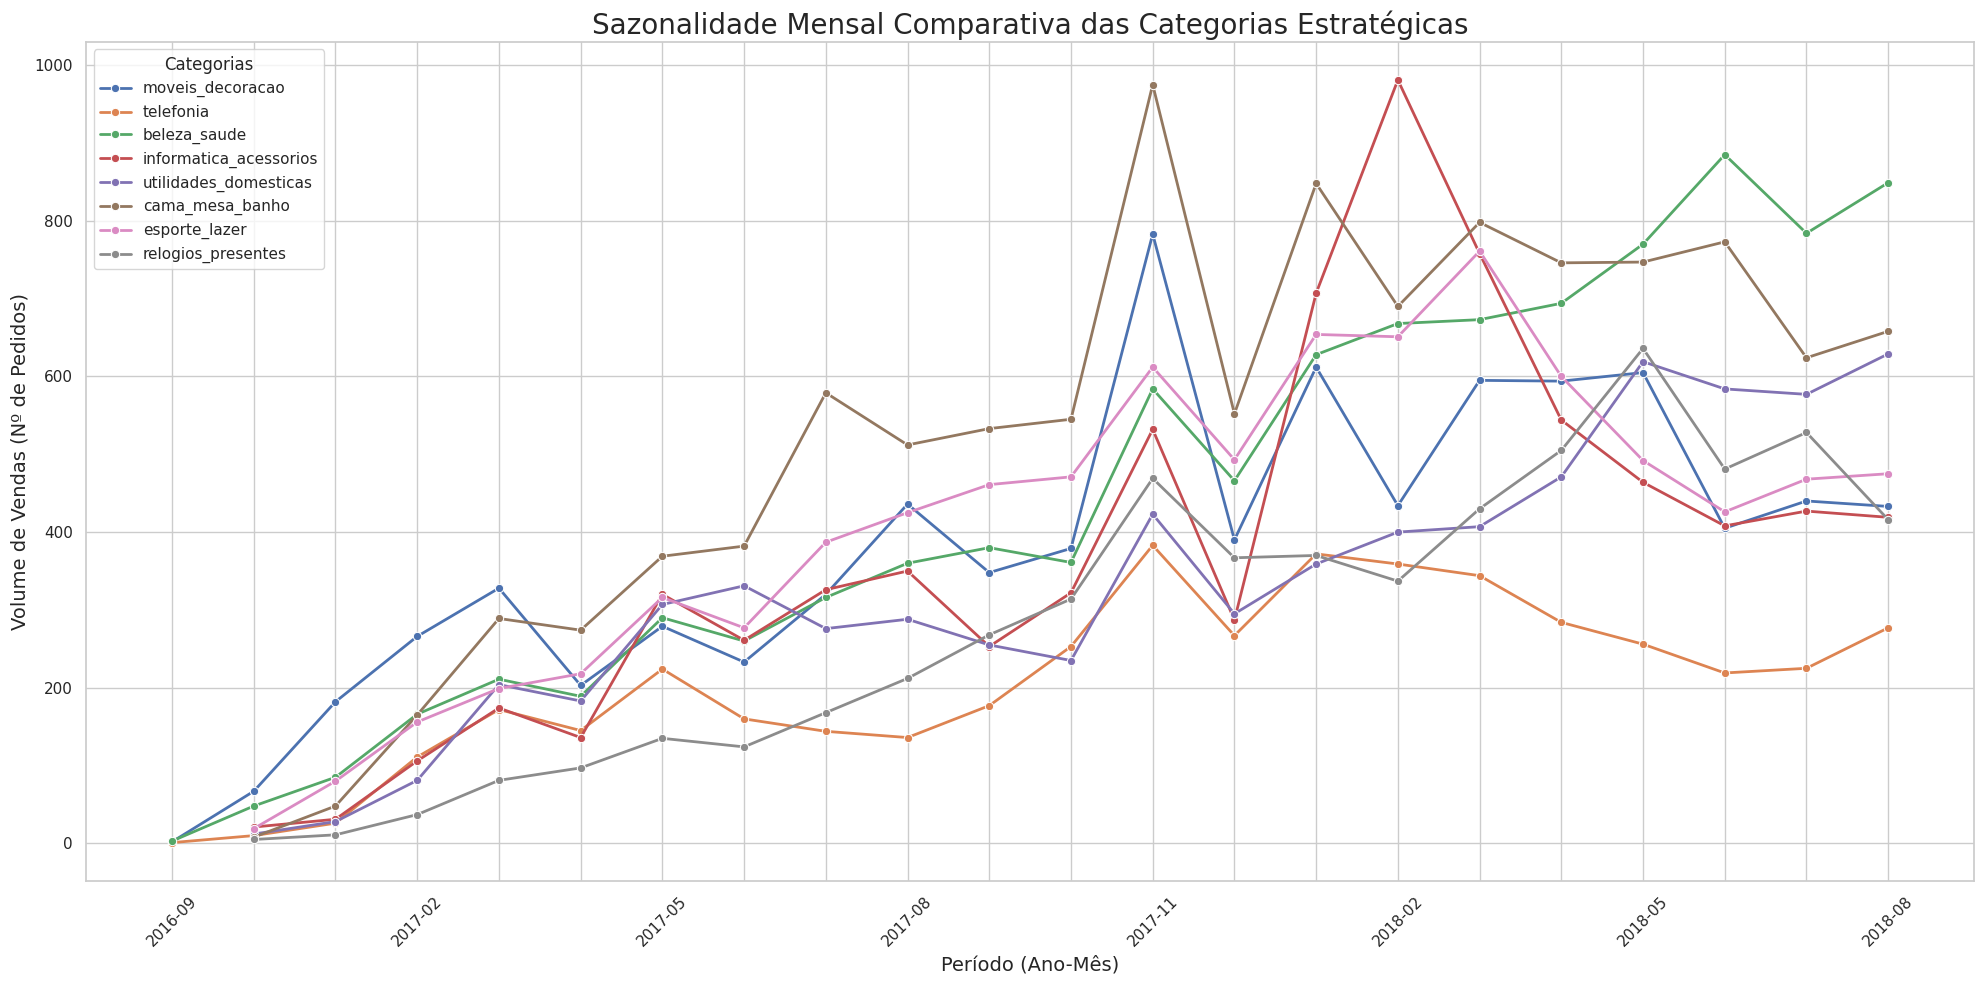

In [0]:
# Etapa 9: Análise Comparativa da Sazonalidade Mensal

# Reutiliza-se a 'lista_categorias_principais' (ex: categorias que somam 60% das vendas)
# definida na Etapa 8, para manter a coerência da análise.

# 1. Filtra-se o DataFrame de vendas mensais para conter dados apenas das categorias principais.
sazonalidade_principais_df = volume_mensal_categoria.filter(
    F.col("product_category_name").isin(lista_categorias_principais)
)

# 2. Prepara-se o DataFrame para a visualização, criando a coluna 'periodo'.
sazonalidade_principais_pd = sazonalidade_principais_df.withColumn(
    "periodo",
    F.concat(F.col("ano"), F.lit("-"), F.format_string("%02d", F.col("mes")))
).orderBy("periodo").toPandas()


# 3. Cria-se o gráfico de linhas para a análise comparativa.
plt.figure(figsize=(20, 10))
sns.set_theme(style="whitegrid")

sns.lineplot(
    data=sazonalidade_principais_pd,
    x="periodo",
    y="total_vendas",
    hue="product_category_name", # Uma cor para cada categoria
    marker="o",
    linewidth=2.0
)

# 4. Adiciona-se títulos e formata-se os eixos para clareza.
plt.title("Sazonalidade Mensal Comparativa das Categorias Estratégicas", fontsize=20)
plt.xlabel("Período (Ano-Mês)", fontsize=14)
plt.ylabel("Volume de Vendas (Nº de Pedidos)", fontsize=14)
plt.xticks(rotation=45)

# Oculta alguns rótulos do eixo X para evitar poluição visual
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 3 != 0:
        label.set_visible(False)

plt.legend(title="Categorias")
plt.tight_layout()
display(plt.gcf())

## Conclusão

As principais conclusões podem ser resumidas nos seguintes pontos:

---

### 🔹 Alta Concentração de Vendas (Princípio de Pareto)

A performance de vendas é fortemente concentrada em um número limitado de categorias. As **8 categorias mais relevantes** (`cama_mesa_banho`, `beleza_saude`, `esporte_lazer`, `moveis_decoracao`, `informatica_acessorios`, `utilidades_domesticas`, `relogios_presentes` e `telefonia`) são responsáveis por **mais de 60% de todo o volume de pedidos**.  
Isso indica que o sucesso do negócio está **intrinsecamente ligado ao desempenho deste portfólio principal**.

---

### 🔹 Crescimento Expressivo ao Longo do Tempo

As séries temporais (mensal e trimestral) mostram uma **clara e robusta tendência de crescimento nas vendas**, especialmente ao comparar o início de 2017 com o de 2018.  
A plataforma demonstrou uma forte capacidade de **expandir seu volume de transações ano a ano**.

---

### 🔹 Sazonalidade Dominada pela Black Friday

O padrão sazonal é inequívoco em todas as categorias estratégicas.  
Há um **pico de vendas massivo em novembro**, indicando que a **Black Friday é o evento comercial mais significativo do ano**.  
Este pico é seguido por uma **queda acentuada em dezembro e no início do ano seguinte**, um comportamento esperado após um período de alta demanda.

---

### 🔹 Comportamento Sincronizado das Categorias

As principais categorias, em geral, seguem o **mesmo padrão sazonal**.  
Isso sugere que **as estratégias de marketing de larga escala, como as da Black Friday, impactam positivamente todo o portfólio principal de forma simultânea**, em vez de beneficiar apenas nichos específicos.